# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Introduction: Business Problem 
  In this project we can figure out for the businessman in Toronto, who will require to open a resturant. W0e will figure out which location will suit the businessman to open the resturant, specifically an Italian resturant.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

## 2. Preparation of the dataframe
Data required for this project has been loaded

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))

df=df[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
#The borough which are not assigned are removed. 
df = df.drop(df[df["Borough"] == "Not assigned"].index)
for i in range(0,df.shape[0]):
    if df.iloc[i,2]=='Not assigned':
        df.iloc[i,2]=df.iloc[i,1]
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [5]:
#dataframes are grouped according to the post code
result = df.groupby(['Postcode','Borough'], sort=False).agg( ', '.join).reset_index()
result.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [6]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


# The following code accesses a file in your IBM Cloud Object Storage.

client_0dbbf3850ee341c2b882fd1bc576829c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='EspvOEyWEBQyvJ8XGBmDQsze4H5EI-Epth1whzUPfMFN',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_0dbbf3850ee341c2b882fd1bc576829c.get_object(Bucket='courseradatasciencecourse-donotdelete-pr-hqz6jwg3ramppr',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
d=result.join(df_data_1.set_index('Postal Code').Latitude, on='Postcode')
data=d.join(df_data_1.set_index('Postal Code').Longitude, on='Postcode')
data.head()
data.shape

(103, 5)

## 3. Exploring data with foursquare API 

In [8]:
CLIENT_ID = '01C3PZRY0GD5SXS3TJY2VQLMAJSEUGUIC3JTQLYTSI2IYUN4' # your Foursquare ID
CLIENT_SECRET = 'SZNXRD4CNZ11E2HP1EQANXV4P0413ML1SEGRID104M0UHE5Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [62]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:

data_venues = getNearbyVenues(names=data['Neighbourhood'],latitudes=data['Latitude'],longitudes=data['Longitude']);

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

In [65]:

print(data_venues.shape)
data_venues.head()

(1687, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [66]:
data_venues.groupby('Neighborhood').count().reset_index()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",50,50,50,50,50,50
1,Agincourt,6,6,6,6,6,6
2,"Agincourt North, L'Amoreaux East, Milliken, St...",4,4,4,4,4,4
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",10,10,10,10,10,10
4,"Alderwood, Long Branch",10,10,10,10,10,10
5,"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
6,Bayview Village,4,4,4,4,4,4
7,"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
8,Berczy Park,50,50,50,50,50,50
9,"Birch Cliff, Cliffside West",4,4,4,4,4,4


In [67]:

# one hot encoding
data_onehot = pd.get_dummies(data_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
data_onehot['Neighborhood'] = data_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [data_onehot.columns[-1]] + list(data_onehot.columns[:-1])
data_onehot = data_onehot[fixed_columns]

data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
data_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.020000,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.02,0.0

## 4.Prediction model

In [68]:
typeR='Café'
X=data_grouped.loc[:, data_grouped.columns!= 'Neighborhood']
X[X > 0]=1;
Xf = pd.DataFrame(data=X)
Xf.head()
y=np.ravel(Xf.loc[:, Xf.columns == typeR])
X=Xf.loc[:, Xf.columns != typeR]
Xf.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (49, 246) (49,)
Test set: (50, 246) (50,)


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [71]:

yhat = LR.predict(X_test)
yhat

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [72]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.46, 0.54],
       [0.53, 0.47],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.5 , 0.5 ],
       [0.52, 0.48],
       [0.52, 0.48],
       [0.51, 0.49],
       [0.52, 0.48],
       [0.44, 0.56],
       [0.53, 0.47],
       [0.48, 0.52],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.52, 0.48],
       [0.51, 0.49],
       [0.52, 0.48],
       [0.52, 0.48],
       [0.51, 0.49],
       [0.52, 0.48],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.43, 0.57],
       [0.53, 0.47],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.49, 0.51],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.47, 0.53],
       [0.52, 0.48],
       [0.52, 0.48],
       [0.44, 0.56],
       [0.51, 0.49],
       [0.52, 0.48],
       [0.49, 0.51],
       [0.52, 0.48],
       [0.53, 0.47],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.53, 0.47],
       [0.53, 0.47],
       [0.51, 0.49],
       [0.53,

In [73]:

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.82

In [74]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[11  7]
 [ 2 30]]


Confusion matrix, without normalization
[[11  7]
 [ 2 30]]


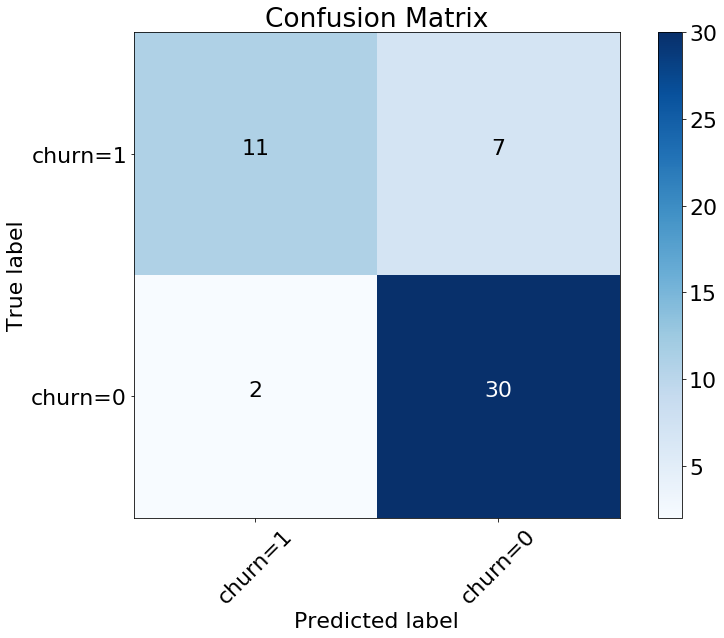

In [75]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 9))
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion Matrix')

In [76]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87        32
         1.0       0.85      0.61      0.71        18

   micro avg       0.82      0.82      0.82        50
   macro avg       0.83      0.77      0.79        50
weighted avg       0.82      0.82      0.81        50



Confusion matrix, without normalization
[[22 12]
 [ 3 62]]


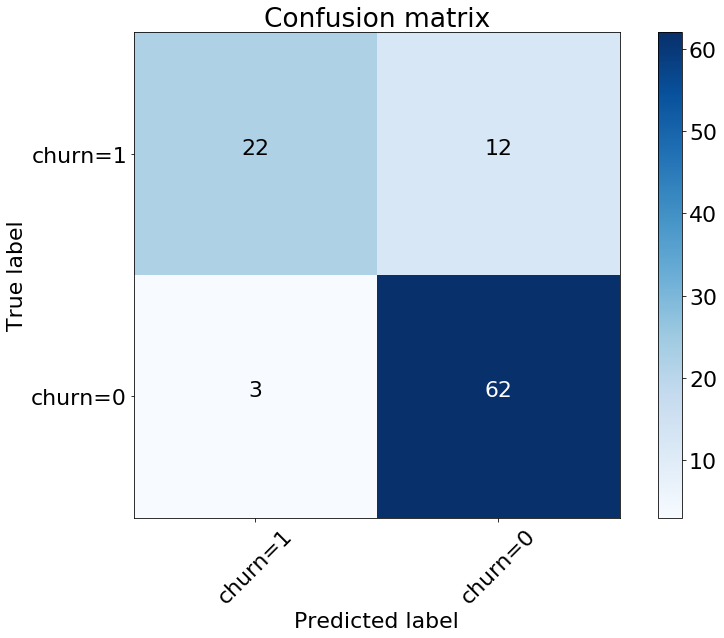

In [77]:
yhat = LR.predict(X)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 9))
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [78]:
kmeans=np.zeros(99)
for i in range(0,99):
    if y[i]==0 and yhat[i]==0:
        kmeans[i]=1
    elif y[i]==1 and yhat[i]==0:
        kmeans[i]=2
    elif y[i]==0 and yhat[i]==1:
        kmeans[i]=3
    else:
        kmeans[i]=4
kmeans

array([4., 1., 1., 1., 1., 1., 2., 4., 4., 2., 2., 2., 1., 1., 1., 4., 1.,
       1., 1., 4., 4., 2., 4., 1., 1., 1., 4., 4., 1., 1., 1., 4., 2., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 4., 1., 1., 3., 1., 4., 4., 4.,
       4., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4., 1., 1., 2.,
       1., 1., 3., 1., 4., 1., 1., 1., 4., 4., 1., 1., 4., 4., 4., 2., 1.,
       1., 3., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1.])

In [79]:

data_temp=pd.DataFrame(data=data_grouped.Neighborhood)
data_temp.head()

data_final=data_temp.join(data_venues.set_index('Neighborhood')['Neighborhood Latitude'], on='Neighborhood')
data_final=data_final.join(data_venues.set_index('Neighborhood')['Neighborhood Longitude'], on='Neighborhood')

data_final.drop_duplicates(inplace=True)
data_final.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,"Adelaide, King, Richmond",43.650571,-79.384568
1,Agincourt,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
4,"Alderwood, Long Branch",43.602414,-79.543484


In [80]:
latitude=43.653963
longitude=-79.387207
# set number of clusters
kclusters = 4
data_final.insert(3, 'Cluster Labels', kmeans)

In [81]:

data_final.astype({'Cluster Labels': 'int'}).dtypes
data_final.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels
0,"Adelaide, King, Richmond",43.650571,-79.384568,4.0
1,Agincourt,43.794200,-79.262029,1.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,1.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,1.0
4,"Alderwood, Long Branch",43.602414,-79.543484,1.0


In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],width=1000,height=600, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_final['Neighborhood Latitude'], data_final['Neighborhood Longitude'], data_final['Neighborhood'], data_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [84]:
data_food = getNearbyVenues(names=data['Neighbourhood'],latitudes=data['Latitude'],longitudes=data['Longitude']);

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

In [85]:

print(data_food.shape)
data_food.head()

(1280, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Latvian Centre Food Market,43.725677,-79.318248,Deli / Bodega


In [86]:
data_food.groupby('Neighborhood').count().reset_index()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",50,50,50,50,50,50
1,Agincourt,4,4,4,4,4,4
2,"Agincourt North, L'Amoreaux East, Milliken, St...",2,2,2,2,2,2
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",5,5,5,5,5,5
4,"Alderwood, Long Branch",4,4,4,4,4,4
5,"Bathurst Manor, Downsview North, Wilson Heights",9,9,9,9,9,9
6,Bayview Village,3,3,3,3,3,3
7,"Bedford Park, Lawrence Manor East",20,20,20,20,20,20
8,Berczy Park,50,50,50,50,50,50
9,"Birch Cliff, Cliffside West",3,3,3,3,3,3


In [87]:
# Create the data frame
typeR='Café'
X=data_food
Xf = pd.DataFrame(data=X)
y=Xf.loc[:, Xf.columns == typeR]
X=Xf.loc[:, Xf.columns != typeR]
Xf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Latvian Centre Food Market,43.725677,-79.318248,Deli / Bodega


In [88]:
Xf.head(50)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Latvian Centre Food Market,43.725677,-79.318248,Deli / Bodega
5,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
6,"Harbourfront, Regent Park",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
7,"Harbourfront, Regent Park",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
8,"Harbourfront, Regent Park",43.654260,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
9,"Harbourfront, Regent Park",43.654260,-79.360636,Brick Street Bakery,43.650574,-79.359539,Bakery


In [89]:

data_onehot = pd.get_dummies(data_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
data_onehot['Neighborhood'] = data_food['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [data_onehot.columns[-1]] + list(data_onehot.columns[:-1])
data_onehot = data_onehot[fixed_columns]

data_food_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
data_food_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.08,0.0,0.06,0.0,0.0,0.02,0.0,0.0,0.02,0.04,0.02,0.02,0.0,0.08,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.04,0.0,0.02,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.02,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.02,0.04,0.02,0.02,0.04,0.0,0.0,0.0,0.0,0.08,0.06,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0
1,Agincourt,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.25,0.00,0.00,0.0,0.00,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.00,0.0,0.50,0.0,0.0,0.50,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.20,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.20,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.25,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


In [90]:
# Create the data frame
typeR='Café'
X=data_food_grouped.loc[:,data_food_grouped.columns!= 'Neighborhood']
Xf = pd.DataFrame(data=X)
y=np.ravel(Xf.loc[:, Xf.columns == typeR])
X=Xf.loc[:, Xf.columns != typeR]
Xf.head()

,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.08,0.0,0.06,0.0,0.0,0.02,0.0,0.0,0.02,0.04,0.02,0.02,0.0,0.08,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.04,0.0,0.02,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.02,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.02,0.04,0.02,0.02,0.04,0.0,0.0,0.0,0.0,0.08,0.06,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0
1,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.25,0.00,0.00,0.0,0.00,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2,0.0,0.00,0.0,0.50,0.0,0.0,0.50,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
3,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.20,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.20,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
4,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.25,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


In [91]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [-5.84 -1.   -0.72 -1.   -1.   -1.   -1.   -1.1   0.07 -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -0.13 -1.   -1.   -1.02 -1.   -1.   -1.
 -0.12  0.07 -0.25 -0.98 -1.   -0.03 -1.02 -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.    0.05 -0.53 -1.   -1.   -1.   -0.12 -1.   -0.21
 -0.97 -1.   -1.   -1.   -1.   -0.72 -0.72 -1.   -1.   -1.   -0.67 -0.93
 -0.97 -1.   -1.   -1.    0.34 -1.   -1.05  0.53 -1.   -1.   -1.26 -1.
 -1.   -1.   -1.   -1.   -0.4   0.09 -0.72 -1.   -1.   -0.68 -1.   -1.
 -1.    0.53 -2.07 -1.   -1.  ]


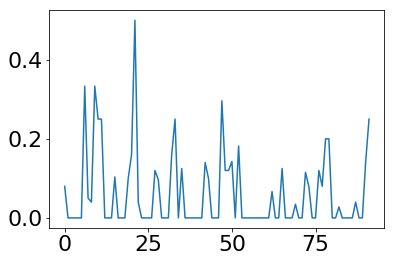

In [92]:
y_hat= regr.predict(X)
plt.plot(y_hat)

In [93]:

data_final.loc[data_final['Cluster Labels']==3]['Neighborhood']

46                       Glencairn
70          Parkdale, Roncesvalles
86    The Danforth West, Riverdale
Name: Neighborhood, dtype: object

In [94]:
print(data_grouped.shape)
num_top_venues = 3

for hood in data_final.loc[data_final['Cluster Labels']==3]['Neighborhood']:
    print("----"+hood+"----")
    temp = data_food_grouped[data_food_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

(99, 248)
----Glencairn----
                 venue  freq
0          Pizza Place   0.4
1     Asian Restaurant   0.2
2  Japanese Restaurant   0.2


----Parkdale, Roncesvalles----
                         venue  freq
0               Breakfast Spot  0.29
1  Eastern European Restaurant  0.14
2           Italian Restaurant  0.14


----The Danforth West, Riverdale----
                venue  freq
0    Greek Restaurant  0.39
1         Pizza Place  0.08
2  Italian Restaurant  0.08




In [95]:
data_final.loc[data_final['Cluster Labels']==4]['Neighborhood']

0                              Adelaide, King, Richmond
7                     Bedford Park, Lawrence Manor East
8                                           Berczy Park
15                          Cabbagetown, St. James Town
19                                   Central Bay Street
20            Chinatown, Grange Park, Kensington Market
22                                 Church and Wellesley
26                       Commerce Court, Victoria Hotel
27                                           Davisville
31             Design Exchange, Toronto Dominion Centre
43               First Canadian Place, Underground city
48                       Harbord, University of Toronto
49    Harbourfront East, Toronto Islands, Union Station
50                            Harbourfront, Regent Park
51                        High Park, The Junction South
64                             Little Portugal, Trinity
72                                         Queen's Park
76                                   Runnymede, 